In [245]:
from astropy.io import fits
import glob
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm, SymLogNorm
from matplotlib.ticker import LogLocator

def flush_current_figs():    
    plt.clf()
    plt.cla()
    plt.close("all")


def multipage(filename, figs=None, dpi=200):
    from matplotlib.backends.backend_pdf import PdfPages
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()




RA Offset = -698.576 +/- 4.046 mas
Dec Offset = 110.647 +/- 4.729 mas
Separation = 707.247 +/- 4.063 mas
PA = 279.022 +/- 0.382 deg
Reference: Ginski et al. 2014b

pwd

In [246]:
def circle(shape: tuple, r: float, offset=(0.5, 0.5)):
    """ Create circle of 1 in a 2D matrix of zeros"
       
       Parameters
       ----------

       shape : tuple
           shape x,y of the matrix
       
       r : float
           radius of the circle
       offset : (optional) float
           offset from the center
       
       Returns
       -------
       M : ndarray
           Zeros matrix with a circle filled with ones
       
    """
    assert(len(shape) == 2 or len(shape) == 3)
    if isinstance(offset, (int, float)): offset = (offset, offset)

    nb_f  = shape[0]  if len(shape) == 3 else 0
    shape = shape[1:] if len(shape) == 3 else shape

    M = np.zeros(shape)
    w, l = shape
    for x in range(0, w):
        for y in range(0, l):
            if pow(x - (w // 2) + offset[0], 2) + pow(y - (l // 2) + offset[1], 2) < pow(r, 2):
                M[x, y] = 1

    if nb_f: M = np.tile(M, (nb_f, 1, 1))

    return M


In [247]:
from vip_hci.metrics import snr
from vip_hci.var import fit_2dgaussian
from vip_hci.preproc import frame_shift

cent_dict = {"2short":(20.25, 18.1), '2long':(19.8,16.9),'2medium':(21.8,17.4),
             "1short":(23.1, 22.7), '1long':(22.4,24.1),'1medium':(22.4,21.9),
             "3short":(26, 22), '3long':(19.8,16.9),'3medium':(21.8,17.4),
             "4short":(20.25, 18.1), '4long':(19.8,16.9),'4medium':(21.8,17.4)}

# cent_dict = {"2short":(19.679302804127097, 18.58641748963188), '2long':(18.32105966669046, 19.065445967346378),'2medium':(19.581114490999788, 18.371843671485763),
#              "1short":(20.11996458342179, 22.664702251101854), '1long':(19.584686949189056, 26.7204089323958),'1medium':(19.606972111667083, 21.18490155390528),
#              "3short": (-202.55097250865572, 172.11748877166605), '3long':(17.8483455540893, 16.267408765504722),'3medium':(-95.79005038012308, 86.14676687334345),
#              "4short": (17.72395596417722, 0.3796534243183469), '4long':(16.23002211142098, 16.096291604964943),'4medium':(16.138886671043704, 18.684868644475458)}

In [248]:

label = "nopsfsub"#"CTandBKGsub"stage3linear_shifted_ddither
star="GQLup"
dir_noPSF  = "../../MINDS_OUTPUTS/"+star+"/stage3"+label+"_ddither/"

chan = str(1)
band = "long"
file = dir_noPSF+"Level3_ifua_psf_ch"+str(chan)+"-"+band+"_s3d_cen.fits"
hdul_noPSF = fits.open(file)

path_lists = file.split("/")
name_file = path_lists[-1]
bandchan = name_file[11:-9]
noPSF_imgs = hdul_noPSF['SCI'].data

mean_noPSF_imgs =  np.nanmedian(noPSF_imgs, axis=0)
hdul_head = hdul_noPSF['SCI'].header
ref_pix_x = hdul_head['CRPIX1']
ref_pix_y = hdul_head['CRPIX2']
pix_to_deg_x = hdul_head['CDELT1']*3600
pix_to_deg_y = hdul_head['CDELT2']*3600   
ref_ex_x =hdul_head['CRVAL1']
ref_ex_y =hdul_head['CRVAL2']


wins=20

len_x, len_y = mean_noPSF_imgs.shape
mid_x_r, mid_y_r = len_y//2, len_x//2
mid_x, mid_y=  cent_dict[chan+band]
print(mid_x_r, mid_y_r)
plt.imshow(mean_noPSF_imgs.clip(min=0))
plt.plot(mid_x_r, mid_y_r, "or")
plt.plot(mid_x, mid_y, "ob")
#plt.xlim([mid_x-wins,mid_x+wins])
#plt.ylim([mid_y-wins,mid_y+wins])


23 23


In [249]:
# plt.close("all")
# plt.figure("test")

# rate = "../DATA/REFSfringe/jw03779002001_03102_00003_mirifushort_rate.fits"
# hdul = fits.open(rate)
# hdul.verify('ignore')
# residual = (hdul[1].data)
# test = 4*(residual[512,:])+0.003452

# plt.plot(test - 4*residual[512,:], label="Negative distortion (*3)")
# # plt.plot(test, label="Normal signal")
# # plt.plot(4*(0.3+residual[512,:]), label="+1")
# plt.plot(test-4*(residual[512,:]+0.03), label="+1")
# plt.legend()


In [250]:

nans_img=np.isnan(mean_noPSF_imgs)
mean_noPSF_imgs[nans_img] = 0
len_y, len_x = mean_noPSF_imgs.shape
mid_x, mid_y=  cent_dict[chan+band]

mean_noPSF_imgs_shifted = frame_shift(mean_noPSF_imgs,len_y/2-mid_y,len_x/2-mid_x, imlib="opencv")


fwhm = 3
mean_noPSF_imgs_shifted[nans_img] = np.nan
pup = (1-circle(mean_noPSF_imgs_shifted.shape,fwhm,offset=(1.5,-1.5)))
# fitparam = fit_2dgaussian(mean_noPSF_imgs_shifted.clip(min=0)*pup, crop=True, cent=(mid_x+0.7,mid_y+4.8), cropsize=15)



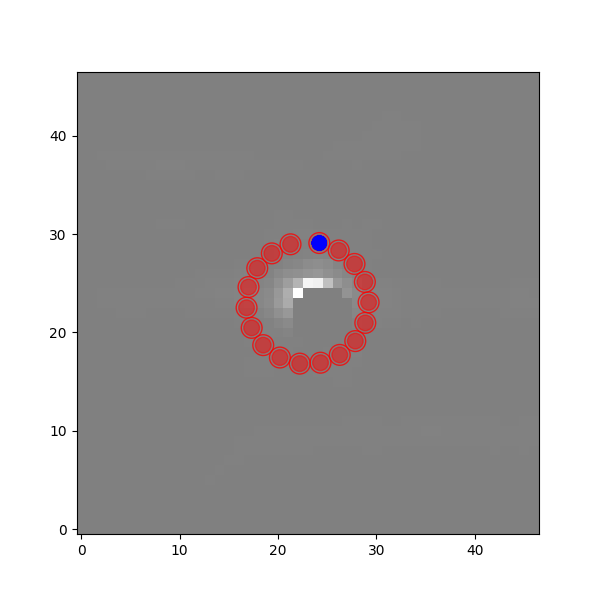

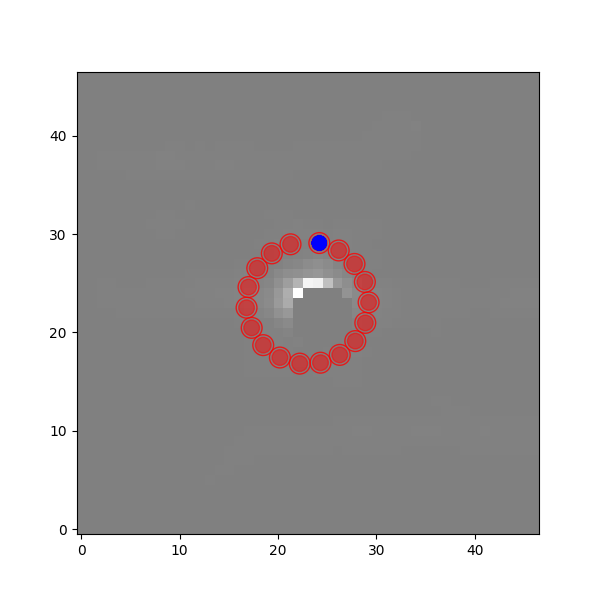

-0.1587217773857049


In [251]:
planet_dict = {"2short":(21.1,24.9), '2long':(21.2,24.8),'2medium':(22.2,26.5),
               "1short":(24.1,28.9), '1long':(24.2,29.1),'1medium':(24.4,29.25),
               "3short":(22.7,31.6), '3long':(24.27,29.0),'3medium':(22.4,21.9),
               "4short":(24.1,28.9), '4long':(24.27,29.0),'4medium':(22.4,21.9)}

fwhm_dic =  {"2short":(7.51+8.77)/2, '2long':(10.01+11.69)/2,'2medium':(8.67+10.13)/2,
             "1short":(4.9+5.74)/2, '1long':(6.53+7.65)/2,'1medium':(5.66+6.63)/2,
             "3short":(11.55+13.47)/2, '3long':(115.41+17.98)/2,'3medium':(13.34+15.57)/2,
             "4short":(17.70+20.95)/2, '4long':(24.40+27.90)/2,'4medium':(20.69+24.48)/2}

fwhm=fwhm_dic[chan+band]/pix_to_deg_y*0.31/8

snr1 = snr(pup*mean_noPSF_imgs_shifted.clip(min=0), source_xy=planet_dict[chan+band], fwhm=fwhm, plot=True)
snr2 = snr(pup*mean_noPSF_imgs_shifted, source_xy=planet_dict[chan+band], fwhm=fwhm, plot=True)

len_x, len_y = mean_noPSF_imgs_shifted.shape
mid_x, mid_y = len_y//2, len_x//2
print(snr2)


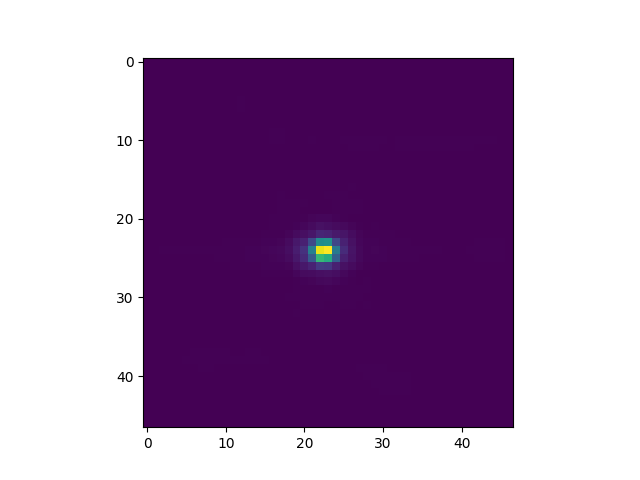

In [252]:
plt.close("all")
plt.imshow((mean_noPSF_imgs))

2.113365462133171


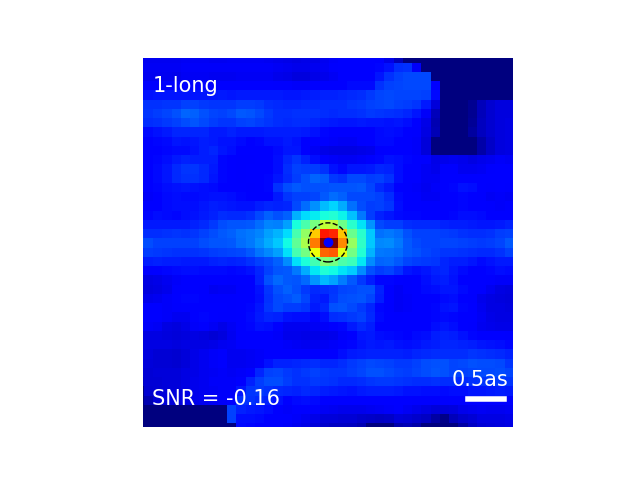

In [253]:
#mean_noPSF_imgs =  np.nanmedian(noPSF_imgs, axis=0)
len_y, len_x = mean_noPSF_imgs.shape
mid_x, mid_y = len_x/2, len_y/2
mid_x, mid_y=  cent_dict[chan+band]
from matplotlib.colors import PowerNorm
plt.close("all")
fwhm_dic =  {"2short":(7.51+8.77)/2, '2long':(10.01+11.69)/2,'2medium':(8.67+10.13)/2,
             "1short":(4.9+5.74)/2, '1long':(6.53+7.65)/2,'1medium':(5.66+6.63)/2,
             "3short":(11.55+13.47)/2, '3long':(115.41+17.98)/2,'3medium':(13.34+15.57)/2,
             "4short":(17.70+20.95)/2, '4long':(24.40+27.90)/2,'4medium':(20.69+24.48)/2}

fwhm=fwhm_dic[chan+band]/pix_to_deg_y*0.31/8
print(fwhm)
aa=plt.figure()

pup = (1-circle(mean_noPSF_imgs.shape,fwhm+1,offset=(len_y/2-mid_y,len_x/2-mid_x)))
#pup = (1-circle(mean_noPSF_imgs.shape,fwhm,offset=(-0.5,-0.5)))

mean_noPSF_imgs_app = mean_noPSF_imgs
plt.imshow(mean_noPSF_imgs_app.clip(min=0.01),
           norm=PowerNorm(0.3),
            cmap="jet",) 
# plt.colorbar(fraction=0.046, pad=0.04, label='Flux (Jy)', )
plt.axis('off')
plt.xlim([mid_x-wins,mid_x+wins])
plt.ylim([mid_y-wins,mid_y+wins])


patch=plt.Circle((mid_x,mid_y),fwhm,ec="black",facecolor='none',ls="--")
plt.gca().add_patch(patch)

plt.plot([mid_x+wins-1,mid_x+wins-1-0.5/pix_to_deg_x],[mid_y-wins+3,mid_y-wins+3],"-",lw=4, c="white")
plt.annotate("0.5as",(mid_x+wins-3.5,mid_y-wins+4),c="white", va="bottom",ha="center",fontsize=15)

plt.plot([mid_x],[mid_y],"ob")

plt.annotate(f"SNR = {snr1:.2f}",(mid_x-wins+1,mid_y-wins+2),c="white", va="bottom",ha="left",fontsize=15)
plt.annotate(str(chan)+"-"+band,(mid_x-wins+1,mid_y+wins-2),c="white", va="top",ha="left",fontsize=15)
plt.show()
# plt.subplots_adjust(left=0, right=0, top=0, bottom=0)
plt.savefig(star+"_"+str(chan)+band+"nopsfsub", bbox_inches='tight', pad_inches=0)



Text(3.3999999999999986, 43.1, '1-long')

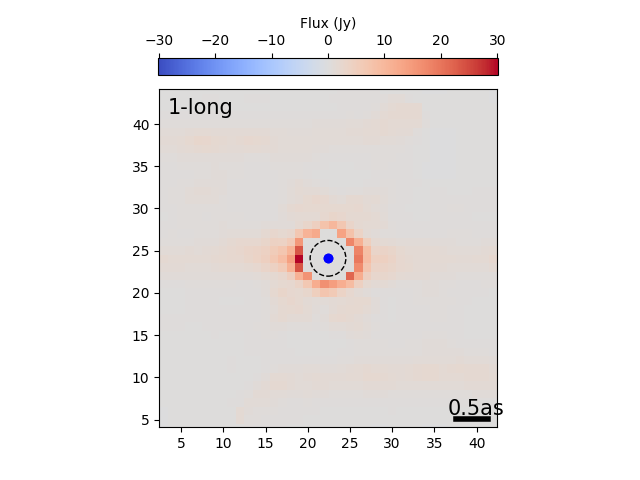

In [254]:
len_x, len_y = mean_noPSF_imgs.shape
mid_x, mid_y = len_y//2, len_x//2
mid_x, mid_y=  cent_dict[chan+band]
plt.figure()
pup = (1-circle(mean_noPSF_imgs.shape,fwhm+1,offset=(len_y/2-mid_y-0.5,len_x/2-mid_x-0.5)))
# pup=1
sig = pup*np.nanmedian(noPSF_imgs, axis=0)
third_len = len(noPSF_imgs)//3

sig1 = pup*np.nanmedian(noPSF_imgs[:third_len], axis=0)
sig2 = pup*np.nanmedian(noPSF_imgs[third_len:2*third_len], axis=0)
sig3 = pup*np.nanmedian(noPSF_imgs[2*third_len:], axis=0)

plt.imshow(sig, cmap="coolwarm",
        vmax=np.nanpercentile(sig,100),
        vmin=-np.nanpercentile(sig,100),
), plt.colorbar(fraction=0.046, pad=0.04, label='Flux (Jy)',  location='top')
patch=plt.Circle((mid_x,mid_y),fwhm,ec="black",facecolor='none',ls="--")
plt.plot([mid_x],[mid_y],"ob")
plt.gca().add_patch(patch)

#plt.axis('off')
plt.xlim([mid_x-wins,mid_x+wins])
plt.ylim([mid_y-wins,mid_y+wins])

plt.plot([mid_x+wins-1,mid_x+wins-1-0.5/pix_to_deg_x],[mid_y-wins+1,mid_y-wins+1],"-",lw=4, c="black")
plt.annotate("0.5as",(mid_x+wins-2.5,mid_y-wins+1),c="black", va="bottom",ha="center",fontsize=15)

plt.plot([mid_x],[mid_y],"ob")

#plt.annotate(f"SNR = {snr2:.2f}",(mid_x-wins+1,mid_y-wins+1),c="black", va="bottom",ha="left",fontsize=15)
plt.annotate(str(chan)+"-"+band,(mid_x-wins+1,mid_y+wins-1),c="black", va="top",ha="left",fontsize=15)

# plt.figure()
# plt.subplot(221),plt.title("Full median")
# plt.imshow(sig, cmap="coolwarm",
#         vmax=np.nanpercentile(sig,99.98),
#         vmin=-np.nanpercentile(sig,99.98),
# ), plt.colorbar(fraction=0.046, pad=0.04, label='Flux (Jy)',  location='right')
# plt.xlim([mid_x-wins,mid_x+wins])
# plt.ylim([mid_y-wins,mid_y+wins])

# plt.subplot(222),plt.title("Median 1st/3")
# plt.imshow(sig1, cmap="coolwarm",
#         vmax=np.nanpercentile(sig,99.98),
#         vmin=-np.nanpercentile(sig,99.98),
# ), plt.colorbar(fraction=0.046, pad=0.04, label='Flux (Jy)',  location='right')
# plt.xlim([mid_x-wins,mid_x+wins])
# plt.ylim([mid_y-wins,mid_y+wins])

# plt.subplot(223),plt.title("Median 2nd/3")
# plt.imshow(sig2, cmap="coolwarm",
#         vmax=np.nanpercentile(sig,99.98),
#         vmin=-np.nanpercentile(sig,99.98),
# ), plt.colorbar(fraction=0.046, pad=0.04, label='Flux (Jy)',  location='right')
# plt.xlim([mid_x-wins,mid_x+wins])
# plt.ylim([mid_y-wins,mid_y+wins])

# plt.subplot(224),plt.title("Median last/3")
# plt.imshow(sig3, cmap="coolwarm",
#         vmax=np.nanpercentile(sig,99.98),
#         vmin=-np.nanpercentile(sig,99.98),
# ), plt.colorbar(fraction=0.046, pad=0.04, label='Flux (Jy)',  location='right')
# plt.xlim([mid_x-wins,mid_x+wins])
# plt.ylim([mid_y-wins,mid_y+wins])

# plt.savefig(star+"_3rds_"+str(chan)+band)#+"_pup")

In [255]:
# plt.close("all")
# planet_dict_corr = planet_dict.copy()
# if True : 
#     from stdatamodels.jwst import datamodels
#     from jwst.datamodels import ModelContainer, SpecModel

#     color = ["#92d3ed","#2f99ff","#16168a","#44d244", "#158a17", "#898913"] 

#     kk = 0
#     ## Apperture photometry
#     for chan in ['1','2'] : 
#         for band in ["short", "medium", "long"] : 

#             file = dir_noPSF+"Level3_ifua_psf_ch"+str(chan)+"-"+band+"_s3d_cen.fits"
#             import photutils
#             hdul = fits.open(file)
#             images = hdul['SCI'].data
            
#             path_lists = file.split("/")
#             name_file = path_lists[-1]
#             bandchan = name_file[11:-9]

#             file_photo = file.replace("_s3d_cen","_x1d")
#             dm = datamodels.open(file_photo)

#             # ## get columns
#             ori_wavelength = dm.spec[0].spec_table['WAVELENGTH']
#             # flux = dm.spec[0].spec_table['FLUX']
#             hdul_head = hdul['SCI'].header
#             pxscale1 = float(hdul_head['CDELT1'])
#             pxscale2 = float(hdul_head['CDELT2'])
#             good_plscs = float(np.mean([pxscale1, pxscale2])*3600)

#             wav = hdul_head['CRVAL3'] 
#             wav_det = hdul_head['CDELT3']    

#             flux=[]
#             for ii, frame in enumerate(images) :
#                 fwhm = (wav + ii*wav_det)/good_plscs*0.31/8
#                 mid_x, mid_y=  cent_dict[chan+band]
#                 len_y, len_x = frame.shape

#                 mean_noPSF_imgs_shifted = frame_shift(mean_noPSF_imgs,len_y/2-mid_y,len_x/2-mid_x, imlib="opencv")
#                 px, py = planet_dict[str(chan)+band]
#                 print(px, py)
#                 px, py = px-len_x/+mid_x, py-len_y/2+mid_y
#                 print(-len_x/+mid_x, -len_y/2+mid_y)
#                 planet_dict_corr[str(chan)+band] = (px, py)
#                 fwhm_aper = photutils.CircularAperture((px, py), fwhm/2)
#                 mask = fwhm_aper.to_mask().to_image(images[0].shape)
#                 flux.append(photutils.aperture_photometry(frame, fwhm_aper,method='exact')["aperture_sum"])

#             flux=np.array(flux)
#             plt.subplot(211)
#             plt.plot(ori_wavelength, flux,'o', lw=1 , ms=1, color=color[kk], label=str(chan)+" "+band)     
#             plt.ylim([0,4])
#             plt.legend(loc="upper right", markerscale=4., fontsize=8)

#             plt.subplot(212)
#             plt.plot(ori_wavelength, flux,'o', lw=1 , ms=1, color=color[kk], label=str(chan)+" "+band)     
#             #plt.ylim([0,4])

#             kk+=1   

#             plt.xlabel("photometry")
#             plt.xlabel(r'$\lambda$')

#             multipage("./AppPhoto.pdf")
    